In [6]:
import pennylane as qml
from pennylane import numpy as np
from featuremaps import qaoa, pars_qaoa
import matplotlib.pyplot as plt
import dill as pickle
import time

In [2]:
np.set_printoptions(precision=5, suppress=True)

CSWAP = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

In [3]:
########################
# Settings
########################
# FIX: For technical reasons, define all kwargs with fixed values (i.e. n_layers=1).
# Make sure these are consistent with the variables below.
def featmap(*args):
    """Wrapper for feature map to define specific keyword arguments."""
    return qaoa(*args, n_layers=4)


n_layers = 4  # number of layers for featuremap, if applicable
n_inp = 1  # number of wires that feature map acts on
n_steps = 300  # steps of GD performed
log_step = 5  # how often the test error is calculated
batch_size = 1  # how many pairs are sampled in each training step
X = np.loadtxt("./data/X_1d_sep.txt", ndmin=2)  # load features
Y = np.loadtxt("./data/Y_1d_sep.txt")  # load labels
name_output = "./trained_embeddings/1d_sep-l2-" + str(n_steps) + "s-" + \
              str(n_layers) + "l-" + str(n_inp) + "w"   # name of output file
init_pars = pars_qaoa(n_wires=n_inp, n_layers=n_layers)  # generate initial parameters with helper function
pennylane_dev = 'default.qubit'
optimizer = qml.RMSPropOptimizer(stepsize=0.01)
plot = True
save_featmap = True
save_plot = True
save_intermediate = True  # whether to save feature map in any log_step of training
#########################

# Use settings to calculate other settings
n_all = 2*n_inp + 1
dev = qml.device(pennylane_dev, wires=n_all)


@qml.qnode(dev, cache=True)
def circuit(weights, x1=None, x2=None):

    # Load the two inputs into two different registers
    featmap(weights, x1, range(1, n_inp+1))
    featmap(weights, x2, range(n_inp+1, 2*n_inp+1))

    # Do a SWAP test
    qml.Hadamard(wires=0)
    for k in range(n_inp):
        qml.QubitUnitary(CSWAP, wires=[0, k+1, n_inp+k+1])
    qml.Hadamard(wires=0)

    # Measure overlap by checking ancilla
    return qml.expval(qml.PauliZ(0))


def tr_rr(weights, A=None):
    # Compute intra-class overlap A
    tr_rr = 0
    for a1 in A:
        for a2 in A:
            tr_rr += circuit(weights, x1=a1, x2=a2)
    tr_rr = tr_rr / len(A)**2
    return tr_rr


def tr_ss(weights, B=None):
    # Compute intra-class overlap B
    tr_ss = 0
    for b1 in B:
        for b2 in B:
            tr_ss += circuit(weights, x1=b1, x2=b2)
    tr_ss = tr_ss/len(B)**2
    return tr_ss


def tr_rs(weights, A=None, B=None):
    # Compute inter-class overlap A-B
    tr_rs = 0
    for a in A:
        for b in B:
            tr_rs += circuit(weights, x1=a, x2=b)
    tr_rs = tr_rs/(len(A)*len(B))
    return tr_rs


def cost(weights, A=None, B=None):

    # Fidelity cost,
    rr = tr_rr(weights, A=A)
    ss = tr_ss(weights, B=B)
    rs = tr_rs(weights, A=A, B=B)
    distance = - rs + 0.5 * (ss + rr)
    return 1 - distance  # min is 0


In [7]:
# Divide inputs into classes
A = X[Y == -1]
B = X[Y == 1]

# Optimise the circuit
cst_history = []
rr_history = []
ss_history = []
rs_history = []
par_history = [init_pars]
pars = init_pars
print("Initial parameters ", init_pars)
cst = cost(pars, A=A, B=B)
print("Initial cost ", 0, " -- ", cst)

if save_featmap:
    featmap_settings = {'pars': pars,
                        'step': 0,
                        'featmap': pickle.dumps(featmap),  # serialise and save_featmap the feature map
                        'n_layers': n_layers,
                        'n_wires': n_inp,
                        'X': X,
                        'Y': Y}
    np.save(name_output + ".npy", featmap_settings)
start_time = time.time()
for i in range(n_steps):

    # Sample a batch of pairs
    selectA = np.random.choice(range(len(A)), size=(batch_size,), replace=True)
    selectB = np.random.choice(range(len(B)), size=(batch_size,), replace=True)
    A_batch = [A[s] for s in selectA]
    B_batch = [B[s] for s in selectB]

    # Walk one optimization step (using all training samples)
    pars = optimizer.step(lambda w: cost(w, A=A_batch, B=B_batch), pars)
    par_history.append(pars)

    if i % log_step == 0 and i != 0:
        cst = cost(pars, A=A, B=B)
        rr = tr_rr(pars, A=A)
        ss = tr_ss(pars, B=B)
        rs = tr_rs(pars, A=A, B=B)
        cst_history.append([i, cst])
        rr_history.append([i, rr])
        ss_history.append([i, ss])
        rs_history.append([i, rs])
        if save_featmap and save_intermediate:
            # Update pars and overwrite
            featmap_settings['pars'] = pars
            featmap_settings['step'] = i
            np.save(name_output + ".npy", featmap_settings)

        print("Step {} -- rs {:2f}-- rr {:2f} -- ss {:2f} -- cst {:2f} -- time {:7f}".
              format(i, rs, rr, ss, cst, (time.time() - start_time)))
# Update pars and overwrite
featmap_settings['pars'] = pars
featmap_settings['step'] = i
np.save(name_output + ".npy", featmap_settings)
print("Training finished.")

Initial parameters  [0.001 0.001 0.001 0.001]
Initial cost  0  --  0.9936180512296336
Step 5 -- rs 0.630930-- rr 0.678287 -- ss 0.596348 -- cst 0.993613 -- time 14.560540
Step 10 -- rs 0.630921-- rr 0.678287 -- ss 0.596354 -- cst 0.993600 -- time 28.936745
Step 15 -- rs 0.630874-- rr 0.678287 -- ss 0.596385 -- cst 0.993538 -- time 43.236371
Step 20 -- rs 0.630633-- rr 0.678303 -- ss 0.596543 -- cst 0.993210 -- time 57.550916
Step 25 -- rs 0.629175-- rr 0.678393 -- ss 0.597484 -- cst 0.991237 -- time 71.862558
Step 30 -- rs 0.619615-- rr 0.678757 -- ss 0.603920 -- cst 0.978276 -- time 86.219813
Step 35 -- rs 0.589788-- rr 0.682212 -- ss 0.623155 -- cst 0.937104 -- time 100.623751
Step 40 -- rs 0.560021-- rr 0.683810 -- ss 0.642219 -- cst 0.897006 -- time 114.910478
Step 45 -- rs 0.497008-- rr 0.685173 -- ss 0.685462 -- cst 0.811691 -- time 129.542442
Step 50 -- rs 0.429136-- rr 0.683038 -- ss 0.734459 -- cst 0.720387 -- time 143.956397
Step 55 -- rs 0.388417-- rr 0.698031 -- ss 0.757634

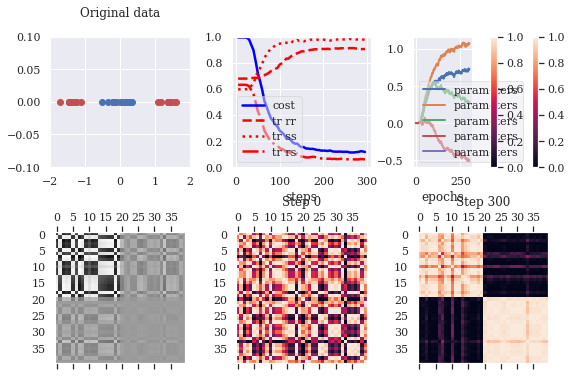

In [8]:
if plot:
    import seaborn as sns
    sns.set(context='notebook', font='serif')

    # Start figure
    fig = plt.figure(figsize=(9, 6))
    # Plotting 1: original data
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.set_title("Original data", pad=20)
    if len(A[0]) == 2:
        ax1.scatter(A[:, 0], A[:, 1], c='r')
        ax1.scatter(B[:, 0], B[:, 1], c='b')
        ax1.set_ylim((-2, 2))
    elif len(A[0]) == 1:
        ax1.scatter(A[:, 0], np.zeros(len(A)), c='r')
        ax1.scatter(B[:, 0], np.zeros(len(B)), c='b')
        ax1.set_ylim((-0.1, 0.1))

    ax1.set_xlim((-2, 2))
    # Plotting 2: gram matrix in original space
    ax5 = fig.add_subplot(2, 3, 4)
    ax5.grid(False)
    X_normal = [x / len(x) for x in X]
    gram_original = [[np.dot(x1, x2) for x1 in X_normal] for x2 in X_normal]
    ax5.matshow(gram_original, cmap='Greys')
    # Plotting 3: untrained gram matrix in Hilbert space
    ax6 = fig.add_subplot(2, 3, 5)
    ax6.set_title("Step 0", pad=20)
    ax6.grid(False)
    gram_before = [[circuit(init_pars, x1=x1, x2=x2) for x1 in X] for x2 in X]
    cax1 = ax6.matshow(gram_before, vmin=0, vmax=1)
    # Plotting 4: trained gram matrix in Hilbert space
    ax7 = fig.add_subplot(2, 3, 6)
    ax7.set_title("Step " + str(n_steps), pad=20)
    ax7.grid(False)
    gram_after = [[circuit(pars, x1=x1, x2=x2) for x1 in X] for x2 in X]
    cax2 = ax7.matshow(gram_after, vmin=0, vmax=1)
    # Plotting 5: cost
    if len(cst_history) > 0:
        ax2 = fig.add_subplot(2, 3, 2)
        cst_history = np.array(cst_history)
        rr_history = np.array(rr_history)
        ss_history = np.array(ss_history)
        rs_history = np.array(rs_history)
        ax2.plot(cst_history[:, 0], cst_history[:, 1],
                 color='blue', marker='', linestyle='-', linewidth=2.5, label="cost")
        ax2.plot(rr_history[:, 0], rr_history[:, 1],
                 color='red', marker='', linestyle='--', linewidth=2.5, label="tr rr")
        ax2.plot(ss_history[:, 0], ss_history[:, 1],
                 color='red', marker='', linestyle=':', linewidth=2.5, label="tr ss")
        ax2.plot(rs_history[:, 0], rs_history[:, 1],
                 color='red', marker='', linestyle='-.', linewidth=2.5, label="tr rs")
        plt.legend(fancybox=True, framealpha=0.5, loc='lower left')
        ax2.set_ylim((0, 1))
        ax2.set_xlabel("steps")


    # Plotting 6
    if len(cst_history) > 0:
        ax3 = fig.add_subplot(2, 3, 3)
        par_history = np.array(par_history)
        for i in range(len(par_history[0])):
            ax3.plot(range(len(par_history)), par_history[:, i], linewidth=2.0, label="parameters")
        ax3.set_xlabel("epochs")
        # fake line for legend
        ax3.plot([], linewidth=2.0, label="parameters")

    fig.colorbar(cax1, orientation="vertical", pad=0.2)
    fig.colorbar(cax2, orientation="vertical", pad=0.2)

    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.legend(fancybox=True, framealpha=0.5, loc='lower left')

    if save_plot:
        plt.savefig(name_output + ".svg")

    plt.show()